# Prepare the software environment

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import Row
from datetime import datetime
import re

In [2]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Internal Access Log Analysis') \
    .getOrCreate()

sc = spark.sparkContext

# Define the regular expression for parsing each line of the log file

In [3]:
ACCESS_LOG_PATTERN = '(\S+) (\S+) (\S+) (\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}\s[+\-]\d{4}) "(\S+) (\S+)\s*(\S*)\s*" (\S+) (\S+) "(\S+)" "(\S+)\s*(\S*\s*\S*)" (\S+) (\S+) (\S+)'
DATETIME_RE = '%Y-%m-%d %H:%M:%S %z'

def parse_apache_log_line(logline):
    match = re.search(ACCESS_LOG_PATTERN, logline)
    if match is None:
        print("No match")
        return None
    date_obj = datetime.strptime(match.group(4), DATETIME_RE)

    return Row(
        ipAddress    = match.group(1),
        clientIdentd = match.group(2),
        userId       = match.group(3),
        dateTime     = match.group(4),
        timestamp    = date_obj.timestamp(),
        date         = date_obj.strftime('%Y-%m-%d'),
        method       = match.group(5),
        endpoint     = match.group(6),
        protocol     = match.group(7),
        responseCode = (match.group(8)),
        port         = (match.group(9)),
        field_10     = match.group(10),
        platform     = match.group(11),
        access_tool  = match.group(12),
        in_byte      = match.group(13),
        out_byte     = match.group(14),
        us_byte      = match.group(15))

In [165]:
test_line = 'localhost - - 2016-12-13 12:52:47 +0100 "GET /server-status?auto HTTP/1.1" rc:200 438 "-" "collectd/5.5.1" in:94 out:636 us:390'
test_row = parse_apache_log_line(test_line)
test_row

Row(access_tool='', clientIdentd='-', date='2016-12-13', dateTime='2016-12-13 12:52:47 +0100', endpoint='/server-status?auto', field_10='-', in_byte='in:94', ipAddress='localhost', method='GET', out_byte='out:636', platform='collectd/5.5.1', port='438', protocol='HTTP/1.1', responseCode='rc:200', timestamp=1481629967.0, us_byte='us:390', userId='-')

# Load the log file

In [7]:
access_logs_raw = sc.textFile('access_logs_201612.txt')

In [8]:
access_logs_raw.count()

2529245

In [9]:
access_logs_parsed = access_logs_raw.map(parse_apache_log_line) \
                .filter((lambda x: x is not None))

access_logs_parsed.count()

2275168

# Analysis
The parser only parsed around 90% of the lines. This means that the regular expression still needs significant improvement so that we don't have to exclude 10% of the data.

In [10]:
access_logs_df = access_logs_parsed.toDF()

In [11]:
type(access_logs_df)

access_logs_df.cache()

DataFrame[access_tool: string, clientIdentd: string, date: string, dateTime: string, endpoint: string, field_10: string, in_byte: string, ipAddress: string, method: string, out_byte: string, platform: string, port: string, protocol: string, responseCode: string, timestamp: double, us_byte: string, userId: string]

# Identify available IP addresses
In this notebook, we mainly focus on the behavior of different IPs.
As shown from the dataframe, the ip address 147.214.18.128 constitutes over 92% of the available rows.
This IP address will be referred to as the VIP.

In [13]:
access_logs_df.groupBy("ipAddress").count().show()

+---------------+-------+
|      ipAddress|  count|
+---------------+-------+
| 147.214.81.243|      8|
|      localhost| 141701|
|147.214.176.155|   4214|
|  147.214.64.44|  11097|
| 147.214.64.148|  17058|
|    153.88.5.88|     16|
| 147.214.17.153|   5711|
| 134.138.165.73|     17|
| 147.214.18.128|2093165|
| 147.214.17.154|   2181|
+---------------+-------+



# Define the granularity of counting IP accesses
We count the access by hour.

In [178]:
@udf(returnType=StringType())
def dayhour(date):
    dateTime = datetime.strptime(date, DATETIME_RE)
    return '%d/%02d/%02d:%02d' % (dateTime.year, dateTime.month, dateTime.day, dateTime.hour)

@udf(returnType=IntegerType())
def hour(date):
    return datetime.strptime(date, DATETIME_RE).hour

# Add the new column day_hour

In [180]:
access_logs_df = access_logs_df.withColumn("day_hour", dayhour(col('dateTime')))
access_logs_df = access_logs_df.withColumn("hour", hour('dateTime'))

In [181]:
access_logs_df.take(1)

[Row(access_tool='(java 1.5)', clientIdentd='-', date='2016-11-27', dateTime='2016-11-27 03:16:03 +0100', endpoint='/rawdata-dispatcher/progress/count?executionId=f5f96b9f-fb86-41f3-9142-375edec95f2f', field_10='-', in_byte='in:244', ipAddress='147.214.18.128', method='GET', out_byte='out:223', platform='Apache-HttpClient/4.3.3', port='22', protocol='HTTP/1.1', responseCode='rc:200', timestamp=1480212963.0, us_byte='us:2545', userId='-', day_of_week=6, hour_of_day='2016/11/27:3', day_hour='2016/11/27:03', hour=3)]

# Count the access for all the rows

In [143]:
pandas_day_hour_all_df = access_logs_df.groupBy("day_hour").count().sort(access_logs_df.day_hour).toPandas()

# Count the access for only the VIP

In [149]:
vip_ipAddress = "147.214.18.128"

pandas_day_hour_vip_df = access_logs_df.where(access_logs_df.ipAddress == vip_ipAddress).groupBy("day_hour").count().sort(access_logs_df.day_hour).toPandas()

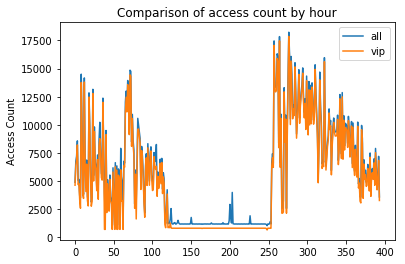

In [170]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(pandas_day_hour_all_df['count'], label='all')
plt.plot(pandas_day_hour_vip_df['count'], label='vip')
plt.title("Comparison of access count by hour")
plt.ylabel("Access Count")
plt.legend(loc="best")
plt.show()

In [174]:
pandas_day_hour_all_df[125:250]

,day_hour,count
125,2016/12/02:08,1235
126,2016/12/02:09,1193
127,2016/12/02:10,1205
128,2016/12/02:11,1314
129,2016/12/02:12,1316
130,2016/12/02:13,1189
131,2016/12/02:14,1216
132,2016/12/02:15,1299
133,2016/12/02:16,1524
134,2016/12/02:17,1279


# Analysis
By comparing the access count of all IPs and VIP over time on hourly basis, we get the intuition that the trend
of the all access count is very similar to the trend of VIP (147.214.18.128).

There is no clear trend or seasonality in the time series. An easy observation is that during the period from 2016/12/02 to 2016/12/07, the access count reached a basin. This is very clear for the IP address, 147.214.18.128.
However, a few spikes appeared. This indicates there are some other IP addresses boosted their access count suddenly.

Given the fact there is no clear trend or seasonality, it might not a good idea to fit a time series forecasting model. Instead, it is more intersting to see why there are a few spikes. Rest of the report will explore it.

In [175]:
pandas_day_hour_all_df[195:205]

,day_hour,count
195,2016/12/05:06,1203
196,2016/12/05:07,1192
197,2016/12/05:08,1203
198,2016/12/05:09,1192
199,2016/12/05:10,1483
200,2016/12/05:11,2939
201,2016/12/05:12,1839
202,2016/12/05:13,1290
203,2016/12/05:14,4003
204,2016/12/05:15,1223


In [194]:
access_10 = access_logs_df.where(access_logs_df.day_hour == '2016/12/05:10').groupBy("ipAddress").count().sort(access_logs_df.ipAddress).toPandas()
access_10

,ipAddress,count
0,147.214.17.153,107
1,147.214.17.154,77
2,147.214.176.155,40
3,147.214.18.128,822
4,147.214.64.148,38
5,147.214.64.44,39
6,localhost,360


In [193]:
outlier_11 = access_logs_df.where(access_logs_df.day_hour == '2016/12/05:11').groupBy("ipAddress").count().sort(access_logs_df.ipAddress).toPandas()
outlier_11

,ipAddress,count
0,147.214.17.153,413
1,147.214.17.154,367
2,147.214.176.155,50
3,147.214.18.128,824
4,147.214.64.148,855
5,147.214.64.44,70
6,localhost,360


In [209]:
calc_percentage = round(col("count") * 100 / float(2275168) ,2)

access_logs_df.groupBy("ipAddress").count().withColumn('Percentage %' , calc_percentage).show()

+---------------+-------+------------+
|      ipAddress|  count|Percentage %|
+---------------+-------+------------+
| 147.214.81.243|      8|         0.0|
|      localhost| 141701|        6.23|
|147.214.176.155|   4214|        0.19|
|  147.214.64.44|  11097|        0.49|
| 147.214.64.148|  17058|        0.75|
|    153.88.5.88|     16|         0.0|
| 147.214.17.153|   5711|        0.25|
| 134.138.165.73|     17|         0.0|
| 147.214.18.128|2093165|        92.0|
| 147.214.17.154|   2181|         0.1|
+---------------+-------+------------+



In [210]:
access_13 = access_logs_df.where(access_logs_df.day_hour == '2016/12/05:13').groupBy("ipAddress").count().sort(access_logs_df.ipAddress).toPandas()
access_13

,ipAddress,count
0,147.214.17.153,6
1,147.214.17.154,8
2,147.214.176.155,32
3,147.214.18.128,824
4,147.214.64.148,34
5,147.214.64.44,26
6,localhost,360


In [187]:
outlier_14 = access_logs_df.where(access_logs_df.day_hour == '2016/12/05:14').groupBy("ipAddress").count().sort(access_logs_df.ipAddress).toPandas()
outlier_14

,ipAddress,count
0,147.214.17.153,27
1,147.214.17.154,37
2,147.214.176.155,779
3,147.214.18.128,822
4,147.214.64.148,1353
5,147.214.64.44,625
6,localhost,360


# Analysis
The access counts at date, 2016/12/05, hour 11, 12, and 14 are very likely to be outliers. It is interesting to see what IP addresses made these accesses.

We can see that the spike at 2016/12/05, hour 11 is mainly caused by the accesses from IP
147.214.17.153,
147.214.17.154,
147.214.64.148.
The spike at 2016/12/05, hour 11 is mainly caused by the accesses from IP
147.214.176.155,
147.214.64.148,
147.214.64.44.

Considering the percentages of these IP addresses, it is reasonable to assume that
during these hours, the accesses from these IP addresses contain anomalies.